In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.animation import FuncAnimation, PillowWriter

In [43]:
class ModelDynamics:
    conf = dict(dt=1e-2)
    props = dict(
        m_d=0.1,                        # Mass of the disk
        m_B=0.4,                        # Mass of connector B
        m_E=0.6,                        # Mass of end-effector E
        m_BE=0.08,                      # Mass of outer rod BE
        m_AD=0.05,                      # Mass of inner rod AD
        R=0.12,                         # Radius of the disk
        l_BE=0.2,                       # Length of outer rod BE
        l_AD=0.3,                       # length of inner rod AD
        I_e=0.5,                        # Moment of inertia for end-effector E aroud CoM
        r_A=np.array([-0.09, -0.11]),   # Coordinate of point A
        theta_g=0,                      # Angle of gravitational force
        g=9.81,                         # Gravitational acceleration
    )

    state = dict(
        theta=None,
        theta_dot=None,
    )

    tau = 0


    def set_state(self, state):
        self.state = state


    def set_tau(self, tau):
        self.tau = tau


    def __init__(self, *props):
        if len(props) == 1:
            self.props = props[0]

        # extra steps for init


    def m_rod(self):
        m_B = self.props["m_B"]
        m_E = self.props["m_E"]
        m_BE = self.props["m_BE"]
        m_AD = self.props["m_AD"]

        return m_B + m_E + m_BE + m_AD


    def I_d(self):
        m_d = self.props["m_d"]
        R = self.props["R"]
        return m_d * R**2 / 2


    def D_norm(self):
        m_AD = self.props["m_AD"]
        m_BE = self.props["m_BE"]
        l_AD = self.props["l_AD"]
        l_BE = self.props["l_BE"]
        m_rod = self.m_rod()
        m_E = self.props["m_E"]

        return (m_AD * l_AD / 2 + m_BE * l_BE / 2 + m_E * l_BE) / m_rod


    def D_theta(self):
        m_B = self.props["m_B"]
        m_BE = self.props["m_BE"]
        m_E = self.props["m_E"]
        m_rod = self.m_rod()

        return (m_B + m_BE + m_E) / m_rod


    def r_B(self):
        #       ┌ R * cos(theta) ┐
        # r_B = |                |   
        #       └ R * sin(theta) ┘

        theta = self.state["theta"]
        R = self.props["R"]

        x_B = R * np.cos(theta)
        y_B = R * np.sin(theta)

        return np.array([x_B, y_B])


    def r_B_dot(self):
        #           ┌ -R * sin(theta) ┐ 
        # r_B_dot = |                 | theta_dot
        #           └  R * cos(theta) ┘ 

        theta = self.state["theta"]
        theta_dot = self.state["theta_dot"]

        R = self.props["R"]

        x_B_dot = -R * np.sin(theta) * theta_dot
        y_B_dot = R * np.cos(theta) * theta_dot

        return np.array([x_B_dot, y_B_dot])


    def alpha(self):
        # alpha = atan2(y_B - y_A, x_B - x_A)

        r_B = self.r_B()
        r_A = self.props["r_A"]

        return np.arctan2(r_B[1] - r_A[1], r_B[0] - r_A[0])


    def rod_norm(self):
        #             ┌ cos(alpha) ┐
        # rod_norm  = |            |   
        #             └ sin(alpha) ┘

        alpha = self.alpha()

        return np.array([np.cos(alpha), np.sin(alpha)])


    def l_AB(self):
        # l_AB = ||r_B - r_A||_2

        r_B = self.r_B()
        r_A = self.props["r_A"]

        return np.linalg.norm(r_B - r_A)


    def r_M(self):
        #                      l_AD
        # r_M = r_A + rod_norm ----
        #                       2

        rod_norm = self.rod_norm()
        r_A = self.props["r_A"]
        l_AD = self.props["l_AD"]

        return r_A + rod_norm * l_AD / 2


    def l_com(self):
        #                 1
        # l_com = l_AB - --- l_AD
        #                 2

        l_AB = self.l_AB()
        l_AD = self.props["l_AD"]

        return l_AB - l_AD / 2


    def l_com_dot(self):
        #              (x_B - x_A + y_B - y_A)(x_B_dot + y_B_dot)
        # l_com_dot = --------------------------------------------  
        #                                l_AB
        
        r_B = self.r_B()
        r_B_dot = self.r_B_dot()
        l_AB = self.l_AB()
        r_A = self.props["r_A"]
        
        return (
            (r_B[0] - r_A[0] + r_B[1] - r_A[1])
            * (r_B_dot[0] + r_B_dot[1])
            / l_AB
        )


    def r_F(self):
        #                       l_BE
        # r_F = r_B + rod_norm  ----
        #                        2

        r_B = self.r_B()
        rod_norm = self.rod_norm()
        l_BE = self.props["l_BE"]

        return r_B + rod_norm * l_BE / 2


    def r_E(self):
        # r_E = r_B + rod_norm * l_BE

        r_B = self.r_B()
        rod_norm = self.rod_norm()
        l_BE = self.props["l_BE"]

        return r_B + l_BE * rod_norm


    def r_com(self):
        #          m_AD * r_A          
        # r_com = ------------ + D_norm * rod_norm + D_theta * r_B 
        #            m_rod  

        D_norm = self.D_norm()
        rod_norm = self.rod_norm()
        D_theta = self.D_theta()
        r_B = self.r_B()
        m_rod = self.m_rod()
        m_AD = self.props["m_AD"]
        r_A = self.props["r_A"]

        return m_AD * r_A / m_rod + D_norm * rod_norm + D_theta * r_B


    def K_alpha(self):
        #            R^2 - x_A * R cos(theta) - y_a * R sin(theta)
        # K_alpha = -----------------------------------------------
        #                                l_AB^2

        theta = self.state["theta"]
        r_B = self.r_B()
        l_AB = self.l_AB()
        R = self.props["R"]

        return (R**2 - r_B[0] * R * np.cos(theta) - r_B[1] * R * np.sin(theta)) / l_AB


    def K_alpha_dot(self):
        #                -R^2 * x_A * sin(theta) + R^2 * y_A * cos(theta) + x_A^3 * sin(theta) -
        # K_alpha_dot = -----------------------------------------------------------------------------
        #                                                        l_AB**4
        #
        #     - x_A^2 * y_A * cos(theta) + x_A * y_A^2 * sin(theta) - y_A^3 * cos(theta)
        #   ------------------------------------------------------------------------------ R * theta_dot
        #                                           l_AB**4
        
        theta = self.state["theta"]
        theta_dot = self.state["theta_dot"]
        s = np.sin(theta)
        c = np.cos(theta)
        l_AB = self.l_AB()
        R = self.props["R"]
        r_A = self.props["r_A"]
        x_A = r_A[0]
        y_A = r_A[1]

        return (
            R
            * (
                -(R**2) * x_A * s
                + R**2 * y_A * c
                + x_A**3 * s
                - x_A**2 * y_A * c
                + x_A * y_A**2 * s
                - y_A**3 * c
            )
            / l_AB**4
            * theta_dot
        )


    def D(self):
        #            ┌ -sin(alpha) ┐                   ┌ -sin(theta) ┐
        # D = D_norm |             | K_alpha + D_theta |             |
        #            └  cos(alpha) ┘                   └  cos(theta) ┘

        theta = self.state["theta"]
        K_alpha = self.K_alpha()
        D_norm = self.D_norm()
        D_theta = self.D_theta()
        alpha = self.alpha()
        v1 = np.array([-np.sin(alpha), np.cos(alpha)])
        v2 = np.array([-np.sin(theta), np.cos(theta)])

        return D_norm * v1 * K_alpha + D_theta * v2


    def D_dot(self):
        #            ┌ -sin(alpha) ┐               ┌ -cos(alpha) ┐                      
        # D = D_norm |             | K_alpha_dot + |             | K_alpha^2 theta_dot +
        #            └  cos(alpha) ┘               └ -sin(alpha) ┘                      
        #
        #            ┌ -cos(theta) ┐
        #   + D_theta|             | theta_dot
        #            └ -sin(theta) ┘

        theta = self.state["theta"]
        theta_dot = self.state["theta_dot"]
        alpha = self.alpha()
        K_alpha = self.K_alpha()
        K_alpha_dot = self.K_alpha_dot()
        D_norm = self.D_norm()
        D_theta = self.D_theta()
        v1 = np.array([-np.sin(alpha), np.cos(alpha)])
        v2 = np.array([-np.cos(alpha), -np.sin(alpha)])
        v3 = np.array([-np.cos(theta), -np.sin(theta)])

        return (
            D_norm * v1 * K_alpha_dot
            + D_norm * v2 * K_alpha**2 * theta_dot 
            + D_theta * v3 * theta_dot
        )


    def I_r(self):
        #       m_AD ╭ 1                    ╮    1
        # I_r = ---- |--- l_AD^2 + 3 l_com^2| + --- m_BE l_BE^2 + I_E + m_E l_BE^2
        #        3   ╰ 4                    ╯    3

        l_com = self.l_com()
        m_AD = self.props["m_AD"]
        m_BE = self.props["m_BE"]
        m_E = self.props["m_E"]
        l_AD = self.props["l_AD"]
        l_BE = self.props["l_BE"]
        I_e = self.props["I_e"]

        return (
            m_AD * (l_AD**2 / 4 + 3 * l_com**2) / 3  
            + m_BE * l_BE**2 / 3
            + I_e
            + m_E * l_BE**2
        )


    def I_r_dot(self):
        # I_r_dot = 2 m_AD * l_com * l_com_dot

        l_com = self.l_com()
        l_com_dot = self.l_com_dot()
        m_AD = self.props["m_AD"]

        return 2 * m_AD * l_com * l_com_dot

    def M(self):
        # M = m_rod * D^T D + I_d + I_r * K_alpha^2

        D = self.D()
        I_r = self.I_r()
        I_d = self.I_d()
        K_alpha = self.K_alpha()
        m_rod = self.m_rod()

        return m_rod * D.T @ D + I_d + I_r * K_alpha**2


    def M_dot(self):
        # M_dot = 2 m_rod * D^T D_dot + I_r_dot * K_alpha^2 + 2 I_r * K_alpha * K_alpha_dot 

        D = self.D()
        D_dot = self.D_dot()
        I_r = self.I_r()
        I_r_dot = self.I_r_dot()
        K_alpha = self.K_alpha()
        K_alpha_dot = self.K_alpha_dot()
        m_rod = self.m_rod()

        return (
            2 * m_rod * D.T @ D_dot
            + 2 * I_r * K_alpha * K_alpha_dot
            + I_r_dot * K_alpha**2
        )


    def P(self):
        # P = m_rod * g * y_com * cos(theta_g)

        r_com = self.r_com()
        m_rod = self.m_rod()
        g = self.props["g"]
        theta_g = self.props["theta_g"]

        return m_rod * g * r_com[1] * np.cos(theta_g)


    def dP_dtheta(self):
        # dP_dtheta = m_rod * g * D_y * cos(theta_g)

        theta_dot = self.state["theta_dot"]
        m_rod = self.m_rod()
        D = self.D()
        g = self.props["g"]
        theta_g = self.props["theta_g"]
        return m_rod * g * D[1] * np.cos(theta_g)


    def ddtheta(self):
        #               1  ╭   1                                     ╮
        # theta_ddot = --- |- --- M_dot * theta_dot - dP_dtheta + tau|
        #               M  ╰   2                                     ╯
        
        theta_dot = self.state["theta_dot"]
        M = self.M()
        M_inv = 1 / M
        M_dot = self.M_dot()
        dP_dtheta = self.dP_dtheta()
        tau = self.tau

        return (tau - dP_dtheta - M_dot / 2 * theta_dot) * M_inv


    def step(self, autostep=True):
        dt = self.conf["dt"]
        theta, dtheta = self.state["theta"], self.state["theta_dot"]
        ddtheta = self.ddtheta()

        new_dtheta = dtheta + ddtheta * dt
        new_theta = theta + dtheta * dt

        if autostep:
            self.set_state({"theta": new_theta, "theta_dot": new_dtheta})
        
        return (self.props["r_A"], self.r_B(), self.r_E())


    def simulate(self, **kwargs):
        dt = self.conf["dt"]
        steps = None
        tspan = None
        if "steps" in kwargs:
            steps = kwargs["steps"]
            tspan = np.linspace(0, steps * self.conf["dt"], steps)
        elif "tspan" in kwargs:
            tspan = kwargs["tspan"]
            steps = (tspan[1] - tspan[0]) / dt

        history = dict(
            r_A=np.zeros((steps, 2)),
            r_B=np.zeros((steps, 2)),
            r_E=np.zeros((steps, 2)),
        )

        history["r_A"][0] = self.props["r_A"]
        history["r_B"][0] = self.r_B()
        history["r_E"][0] = self.r_E()

        for i in range(steps):
            self.step()
            history["r_A"][i] = self.props["r_A"]
            history["r_B"][i] = self.r_B()
            history["r_E"][i] = self.r_E()

        return history

    def energy(self):
        #      1
        # E = --- M * D^T D * theta_dot^2 + P
        #      2

        theta_dot = self.state["theta_dot"]
        M = self.M()
        D = self.D()
        P = self.P()

        return M * D.T @ D * theta_dot **2 + P

In [44]:
model = ModelDynamics()

In [45]:
model.set_state({"theta": 0, "theta_dot": 0})
model.set_tau(0)
r_A, r_B, r_E = model.simulate(steps=5000).values()

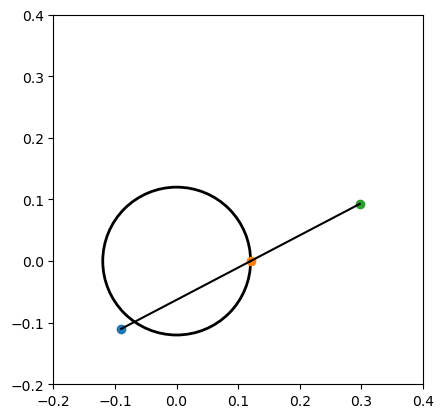

In [42]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(-0.2, 0.4)
ax.set_ylim(-0.2, 0.4)


def animate(frame):
    ax.clear()
    ax.set_aspect("equal")
    ax.set_xlim(-0.2, 0.4)
    ax.set_ylim(-0.2, 0.4)

    # add cirlcle patch to ax
    ax.add_patch(
        patches.Circle([0, 0], model.props["R"], fill=False, color="k", linewidth=2)
    )

    ax.plot(r_A[frame][0], r_A[frame][1], "o")
    ax.plot(r_B[frame, 0], r_B[frame, 1], "o")
    ax.plot(r_E[frame, 0], r_E[frame, 1], "o")

    ax.plot([r_A[frame, 0], r_B[frame, 0]], [r_A[frame, 1], r_B[frame, 1]], "k")
    ax.plot([r_B[frame, 0], r_E[frame, 0]], [r_B[frame, 1], r_E[frame, 1]], "k")

    return ax


anim = FuncAnimation(fig, animate, frames=1000, interval=1)
anim.save("assets/animation.gif", writer=PillowWriter(fps=60))